<a href="https://colab.research.google.com/github/kermityan/EPAM-DS-ML-Course-Notebooks/blob/main/OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! apt install tesseract-ocr > /dev/null
! apt install libtesseract-dev > /dev/null

In [ ]:
! pip install Pillow > /dev/null
! pip install pytesseract > /dev/null

In [ ]:
!pip install transformers > /dev/null

In [ ]:
!pip install sklearn_crfsuite > /dev/null

In [ ]:
! pip install nerval > /dev/null

In [ ]:
! pip install git+https://www.github.com/keras-team/keras-contrib.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-ec3i_1h7


In [ ]:
!pip install tensorflow==2.2

ERROR: Could not find a version that satisfies the requirement tensorflow==2.2 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0)
ERROR: No matching distribution found for tensorflow==2.2


In [ ]:
!pip install keras==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.8/377.8 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.3.1 which is incompatible.


In [ ]:
! pip install tensorflow_addons > /dev/null

In [ ]:
! pip install tf_crf_layer > /dev/null

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from difflib import SequenceMatcher

import pytesseract
from pytesseract import Output
import cv2
from PIL import ImageEnhance, ImageFilter, Image
from imutils.perspective import four_point_transform
import imutils
from ast import literal_eval
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

from sklearn_crfsuite import CRF
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics


from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
from nerval import plot_confusion_matrix
from nerval import crm

from google.colab.patches import cv2_imshow

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/MyDrive/ds_data/OCR/data/"
FILE_PATH = "/content/drive/MyDrive/ds_data/OCR/"

Mounted at /content/drive


Bunch of preprocessing functions:

In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

# bluring
def blur(image):
    return cv2.GaussianBlur(image, (5, 5,), 0)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
  coords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [ ]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

In [ ]:
def deskew(image):
  co_ords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(co_ords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC,
  borderMode=cv2.BORDER_REPLICATE)

  return rotated

In [ ]:
def show_concated(imgs: list):
  hconcated_imgs = np.concatenate(imgs, axis=1)
  cv2_imshow(hconcated_imgs)

Preprocessing experiments:

In [ ]:
img_name = "X00016469623.jpg"

In [ ]:
img = cv2.imread(DATA_PATH + img_name)

In [ ]:
gray = get_grayscale(img)
thresh = thresholding(gray)
open_img = opening(gray)
can_img = canny(gray)

In [ ]:
images = [gray, thresh, open_img, can_img]

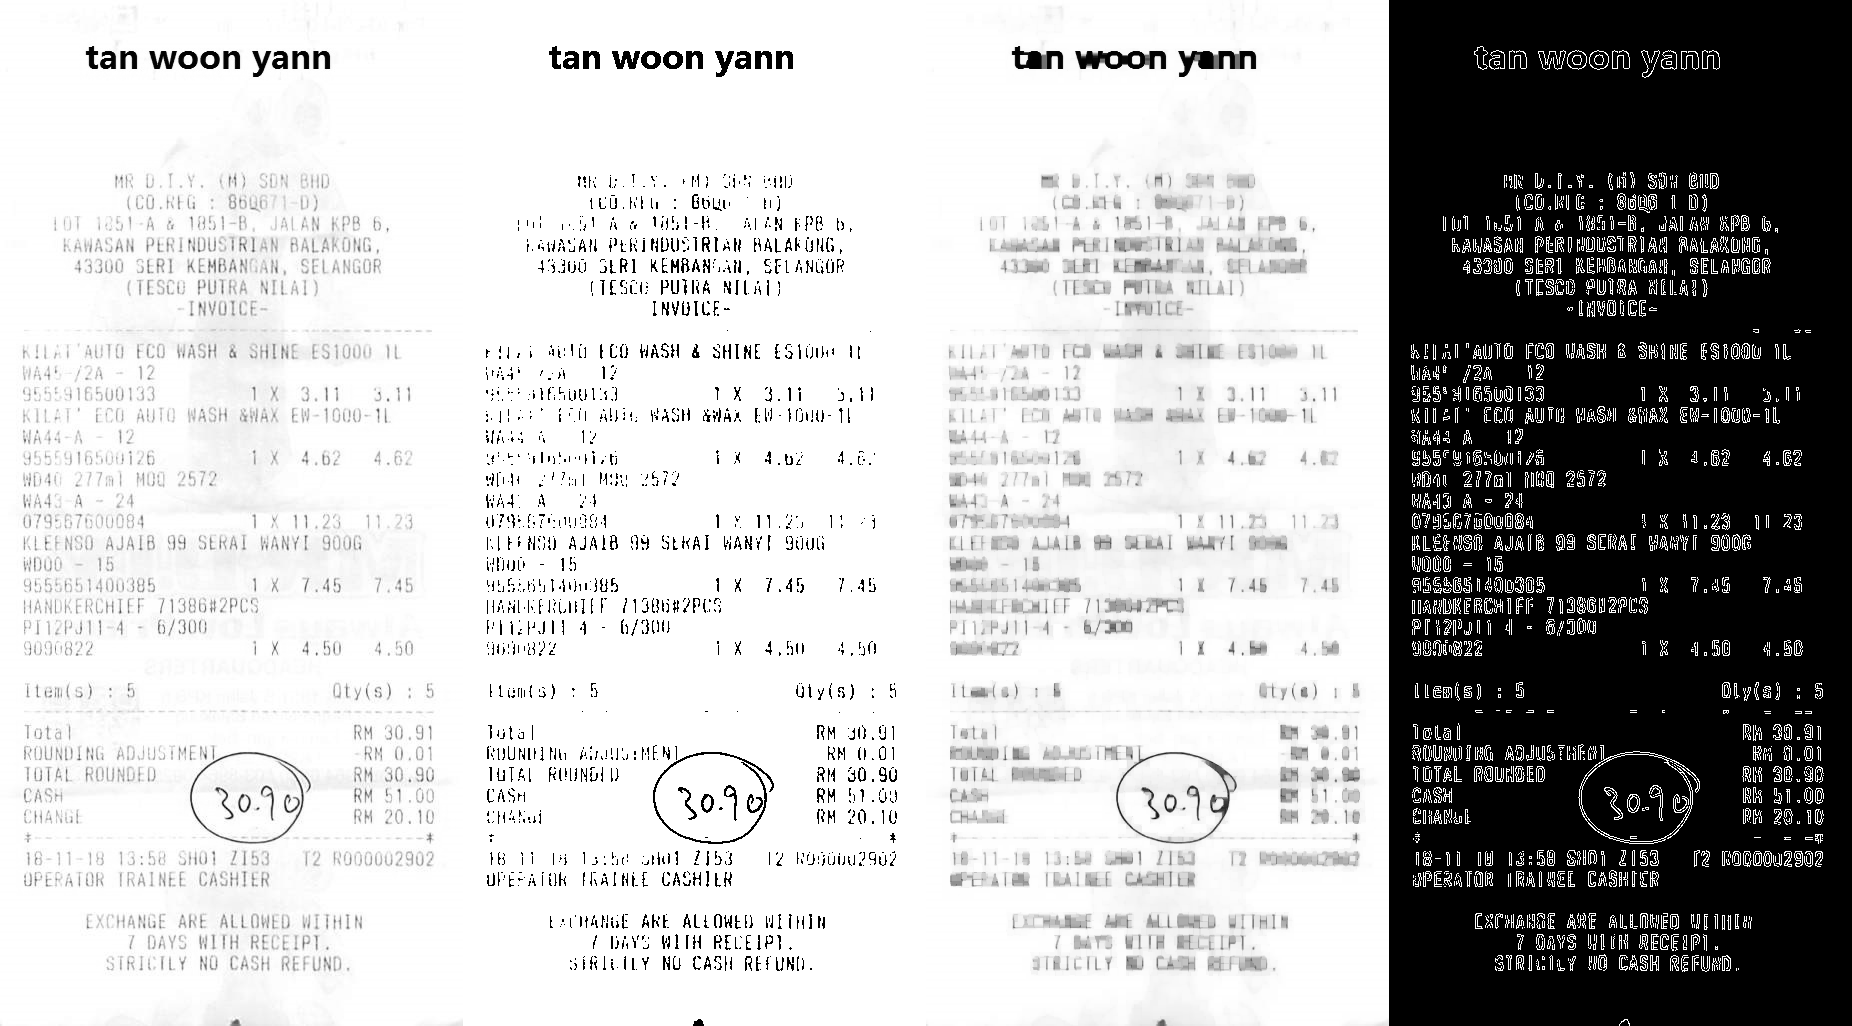

In [ ]:
hconcated_imgs = np.concatenate(images, axis=1)
cv2_imshow(hconcated_imgs)

Function for drawing boxes for chars and words:

In [ ]:
def img_to_boxes(image, char_or_word = 0, height=600):
  img = image.copy()
  if len(img.shape) == 3:
    h, w, c = img.shape
  else:
    h, w = img.shape
  if char_or_word:
    d = pytesseract.image_to_data(img, output_type=Output.DICT)
    n_boxes = len(d['text'])
    for i in range(n_boxes):
      if int(d['conf'][i]) > 55:
          text = d['text'][i]
          text_stripped = "".join([c if ord(c) < 128 else "" for c in text]).strip()
          (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
          img_boxes = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
          #cv2.putText(img, text_stripped, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
  else:
    boxes = pytesseract.image_to_boxes(img)
    for b in boxes.splitlines():
        b = b.split(' ')
        img_boxes = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
  boxes_resized=ResizeWithAspectRatio(img_boxes, height=height)
  cv2_imshow(boxes_resized)
  return img_boxes

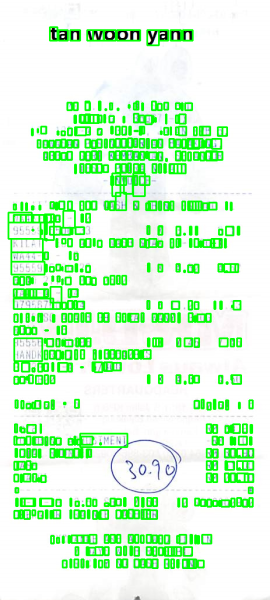

In [ ]:
image_char_boxes = img_to_boxes(img)

In [ ]:
d = pytesseract.image_to_data(thresh, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [ ]:
for text, conf in zip(d['text'],d["conf"]):
  if conf>55:
    print(f'{text} - {conf}')

tan - 92
woon - 92
yann - 92
  - 95
ALAN - 71
RPE - 57
b, - 57
45.400 - 71
SER] - 64
SELANGOR - 86
   - 95
  - 95
ECG - 85
WASH - 70
& - 70
SHINE - 79
Ut - 59
TX - 91
   - 95
  - 95
  - 95
  - 95
  - 95
  - 95
al - 75
Th - 67
4.8, - 61
Ma - 61
4 - 66
AJALB - 72
99 - 75
hub - 57
- - 78
15 - 73
7.45 - 57
7.45 - 74
  - 95
  - 95
TX - 59
4,40 - 58
4,50 - 73
5 - 59
Tata - 61
| - 61
RN - 58
30.91 - 58
RN - 80
0.01 - 79
RM - 80
30.90 - 80
CASH - 94
RM - 69
20.10 - 68
+ - 67
CASHIER - 58
  - 95
ARE - 93
ALLOWED - 88
WETHIN - 74
f - 68
RECEIPT. - 69
NO - 62
CASH - 84
REFUND. - 79


In [ ]:
len(img.shape)

3

### OCR Pipeline

In [ ]:
def load_images_from_folder(folder, filenames=None):
    images = []
    file_list = img_filenames if img_filenames else os.listdir(folder)
    for filename in file_list:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
def select_images(folder):
  imgs = []
  for filename in os.listdir(folder):
    splitted_name = filename.split('.')
    f_n, ext = splitted_name[0], splitted_name[-1]
    if ext == 'jpg':
      imgs.append(filename)
  return imgs

In [ ]:
img_filenames = select_images(DATA_PATH)
img_filenames[:10]

['X51005745214.jpg',
 'X51005746140.jpg',
 'X51005749895.jpg',
 'X51005745296.jpg',
 'X51007846305.jpg',
 'X51005757273.jpg',
 'X51005757286.jpg',
 'X51007846307.jpg',
 'X51005757248.jpg',
 'X51005757243.jpg']

In [ ]:
len(img_filenames)

626

Loading images from the folder:

In [ ]:
img_collection = load_images_from_folder(DATA_PATH, img_filenames)

In [ ]:
len(img_collection)

626

Function for images processing:

In [ ]:
def img_processing(source_img):
  # normalization
  norm_img = np.zeros((source_img.shape[0], source_img.shape[1]))
  img = cv2.normalize(source_img, norm_img, 0, 255, cv2.NORM_MINMAX)

  clean = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 15)

  gray = cv2.cvtColor(clean, cv2.COLOR_BGR2GRAY)

  tresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


  #deskewed = deskew(gray)


  return tresh

In [ ]:
ner_tags = {
    'company':['B-cmp', 'I-cmp'],
    'date':['B-dat', 'I-dat'],
    'address':['B-addr', 'I-addr'],
    'total':['B-tot', 'I-tot'],
}

In [ ]:
receipt = img_collection[15]


In [ ]:
processed_img = img_processing(receipt)

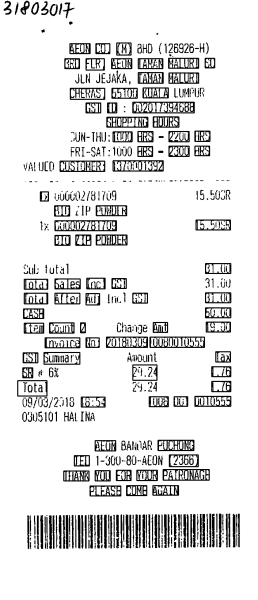

In [ ]:
aaa=img_to_boxes(processed_img,1)

Trying to get text from the image:

In [ ]:
options = "--psm 4"
text = pytesseract.image_to_string(
	cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB),
	config=options)
# show the raw output of the OCR process
print("[INFO] raw output:")
print("==================")
print(text)
print("\n")

[INFO] raw output:
3/€0301F

.

AEON CO. (M} @HD (126926-H)
SRD FLR, AEON TAMEN MALURI SC
JuN JEGAKA, TAMAN MALURT
CHERAS, 55700 KUALA LUMPUR
GST 1D ; 002017394688
SHOPPING HOURS
SUN- THY: 1000 HRS - 2200 HRS
FRI-SAT: 1000 HRS - 2300 HRS
VALUED CUSTOMER: 1970001992
Tx wobo02/81709 15. 500R
AIO CIP POWDTR
Ix 600002781709 15.5058
BIO ZIP POHDER

Sub tutal 31.00
lotal Sales Inc} GST 31.0
Total After Auj trl SST 31.00
CASH 50.00
Tiem Count 2 Change Ant 18.90
Invoice No: 20180309 10080010555
GST Summary Amount Tax
SR a 6X 24.24 1.76
Total 24.24 1.76
OO/03/2518 16:54 1008 061 0010555

O305101 HAL INA

AEGON BANCAR PUCHONG
TEL 1-300-80-AEON (2366)
THANK YOU FOR YOUR PATRONAGE
PLEASE COME AGAIN

en





In [ ]:
text

'3/€0301F\n\n.\n\nAEON CO. (M} @HD (126926-H)\nSRD FLR, AEON TAMEN MALURI SC\nJuN JEGAKA, TAMAN MALURT\nCHERAS, 55700 KUALA LUMPUR\nGST 1D ; 002017394688\nSHOPPING HOURS\nSUN- THY: 1000 HRS - 2200 HRS\nFRI-SAT: 1000 HRS - 2300 HRS\nVALUED CUSTOMER: 1970001992\nTx wobo02/81709 15. 500R\nAIO CIP POWDTR\nIx 600002781709 15.5058\nBIO ZIP POHDER\n\nSub tutal 31.00\nlotal Sales Inc} GST 31.0\nTotal After Auj trl SST 31.00\nCASH 50.00\nTiem Count 2 Change Ant 18.90\nInvoice No: 20180309 10080010555\nGST Summary Amount Tax\nSR a 6X 24.24 1.76\nTotal 24.24 1.76\nOO/03/2518 16:54 1008 061 0010555\n\nO305101 HAL INA\n\nAEGON BANCAR PUCHONG\nTEL 1-300-80-AEON (2366)\nTHANK YOU FOR YOUR PATRONAGE\nPLEASE COME AGAIN\n\nen\n\x0c'

In [ ]:
filename = img_filenames[15].split('.')[0]

Getting JSON with targets from .txt file:

In [ ]:
with open(DATA_PATH + filename +'.txt') as f:
    lines = f.read()
parsed_json = json.loads(lines)

In [ ]:
parsed_json

{'company': 'AEON CO. (M) BHD',
 'date': '09/03/2018',
 'address': '3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR',
 'total': '31.00'}

Creating dictionary with all possible tags:

Auxiliary functions:

In [ ]:
def text_preprocess(text):
  return text.replace("\n", " ")

In [ ]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [ ]:
def sim_search(token, searchstr):
  idx = -1
  search_list = searchstr.split()
  for i in range(len(search_list)):
    if similar(token, search_list[i])>=0.75:
      idx = i

  return idx

Function assigning tags to the text using ground truth from given JSON:

In [ ]:
def assign_tags(text, ground):
  tokens = text.split()
  encoded_text = []

  for t in tokens:
    item = ('O', t)

    for key in ground.keys():
      if t in ground[key].split():
        item = (ner_tags[key][0], t) if t == ground[key].split()[0] else (ner_tags[key][1], t)
        break
      elif key != 'total':
        similar_idx = sim_search(t, ground[key])
        if similar_idx !=-1:
          item = (ner_tags[key][0], t) if similar_idx == 0 else (ner_tags[key][1], t)
          break

    encoded_text.append(item)

  for tag in ner_tags.keys():
    if tag == 'company' or tag == 'address':
      last_id, beg_id = -1, -1
      for i in range(len(encoded_text)):
        if encoded_text[i][0]==ner_tags[tag][0]:
          beg_id = i
          break
        elif encoded_text[i][0]==ner_tags[tag][1]:
          if beg_id == -1:
            beg_id = i
          else:
            last_id = i

      if last_id != -1 and beg_id != -1:
        new_item = (ner_tags[tag][0], encoded_text[beg_id][1])
        encoded_text[beg_id] = new_item
        if last_id-beg_id > 1:
          for i in range(1,last_id-beg_id):
            new_item = (ner_tags[tag][1], encoded_text[beg_id+i][1])
            encoded_text[beg_id+i] = new_item

  return encoded_text

In [ ]:
enc_text = assign_tags(text_preprocess(text), parsed_json)
enc_text

Creating vocabulary out of the text corpus:

In [ ]:
def get_vocab(col):
  corpus = ""
  for text in col:
    if type(text)==list:
      text = ' '.join(text)
    try:
      corpus += text
    except:
      print(text)
    corpus += ' '

  vocab = list(set(corpus.split()))

  return vocab

####Train-test split

In [ ]:
train_split = round(len(img_collection)*0.80)
train_split

501

In [ ]:
train_split=501

In [ ]:
train_imgs = img_collection[:train_split]
test_imgs = img_collection[train_split:]

In [ ]:
train_filenames = img_filenames[:train_split]
test_filenames = img_filenames[train_split:]

Setting up Tesseract engine: --psm 4 - "Assume single column of text of variable sizes", --oem 1 - use LSTM engine

In [ ]:
options = "--psm 4 --oem 1"

Loop through image collection and get texts using Tesseract:

In [ ]:
train_corpus = []
train_data = []

for idx in range(len(train_imgs)):
  text = pytesseract.image_to_string(img_processing(train_imgs[idx]), config=options)
  text = text_preprocess(text)
  train_corpus.append(text)

In [ ]:
len(train_corpus)

501

In [ ]:
train_corpus[:1]

['Py 99 SPEED MART S/B (519537-X) LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR  1132-PI 56 6ST ID. NO s 000181747712  INVOICE NO : 18301/102/T0305  03: 16PHi 569337 07-02-18  2471 888 LYCHEES IN SYRUP S = RM10,14 s 03 X RK 3.38  270_C5R 6 CSR GULA 12%1K6* RM3S.20 z  eae ee einen nen eecenee  Total Sales (Inclusive GST) RM 45.34  Rounding Adjustment RM Ot Rounding RM 45.35 ~  CREDIT RM = 45,35  CHANGE RM 00  6ST Sumnary Amount (RH) Tax(RM)  s 2 Of 9.S7 5? z= 0s 38.20 00 A526  Thank You. Please come again Keep the invoice for applicable returns    \x0c']

Saving train_corpus list (to save time on image recognition in future):

In [ ]:
with open(DATA_PATH+'train_corpus.txt', 'w') as f:
    for line in train_corpus:
        f.write(f"{line}\n")

**Loading train_corpus list:**

In [ ]:
train_corpus = []
with open(DATA_PATH+'train_corpus.txt', 'r') as f:
  for line in f:
    train_corpus.append(line.strip())

In [ ]:
train_corpus[0]

'Py 99 SPEED MART S/B (519537-X) LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR  1132-PI 56 6ST ID. NO s 000181747712  INVOICE NO : 18301/102/T0305  03: 16PHi 569337 07-02-18  2471 888 LYCHEES IN SYRUP S = RM10,14 s 03 X RK 3.38  270_C5R 6 CSR GULA 12%1K6* RM3S.20 z  eae ee einen nen eecenee  Total Sales (Inclusive GST) RM 45.34  Rounding Adjustment RM Ot Rounding RM 45.35 ~  CREDIT RM = 45,35  CHANGE RM 00  6ST Sumnary Amount (RH) Tax(RM)  s 2 Of 9.S7 5? z= 0s 38.20 00 A526  Thank You. Please come again Keep the invoice for applicable returns'

Assigning tags using previously defined function:

In [ ]:
train_data_proc = []
for i in range(len(train_corpus)):
  filename = train_filenames[i].split('.')[0]
  with open(DATA_PATH + filename +'.txt') as f:
    lines = f.read()
  parsed_json = json.loads(lines)
  enc_text = assign_tags(text_preprocess(train_corpus[i]), parsed_json)
  train_data_proc.append(enc_text)

In [ ]:
len(train_data_proc)

501

In [ ]:
train_data_proc[2]

[('O', '¥'),
 ('O', 'r'),
 ('O', 'Mi.'),
 ('O', 'J.f.'),
 ('O', '7.'),
 ('B-cmp', '(M)'),
 ('I-cmp', 'SON'),
 ('I-cmp', 'BHD'),
 ('O', 'C.-RE'),
 ('O', 'i:'),
 ('O', '360671-D'),
 ('B-addr', 'LOT'),
 ('I-addr', '1851-A'),
 ('I-addr', '&'),
 ('I-addr', '1351-B,'),
 ('I-addr', 'JALAN'),
 ('I-addr', 'KPB'),
 ('I-addr', '6,'),
 ('I-addr', 'KAWASAN'),
 ('I-addr', 'PFRINJUSTRIAN'),
 ('I-addr', 'BALAKONG,'),
 ('I-addr', '49300'),
 ('I-addr', 'SERI'),
 ('O', 'K'),
 ('O', 'M34NGAN,'),
 ('I-addr', 'SELANGOR'),
 ('O', '(GST'),
 ('O', '12'),
 ('O', 'No'),
 ('O', ':300306020352)'),
 ('O', '(TESCO'),
 ('O', 'E<PR+i'),
 ('O', 'ARA'),
 ('O', 'DAMANSARA;'),
 ('O', 'VAX'),
 ('O', 'INVOICE'),
 ('O', 'PHILAR'),
 ('O', 'SINw'),
 ('O', 'Tae'),
 ('O', '#5'),
 ('O', 'FlUz'),
 ('O', '-'),
 ('O', '6/54'),
 ('O', '907235]'),
 ('O', '2%'),
 ('O', '23.90'),
 ('O', '47.8C'),
 ('O', "Sh.F'DTUX"),
 ('O', '©'),
 ('O', 'IK'),
 ('O', '500'),
 ('O', '{1L'),
 ('O', 'MP'),
 ('O', '4S'),
 ('O', 'WAUT'),
 ('O', '-'),
 ('O', 

Creating vocab over the corpus:

In [ ]:
train_vocab = get_vocab(train_corpus)
train_vocab[:20]

['refund',
 '17-6,',
 'LO',
 '43.60',
 'UD.',
 'Roundingag',
 'DIGI',
 'King',
 '-2.90',
 'Uescr',
 '{399040',
 '3.51%',
 'Bi',
 'LUT',
 'Riclsecana',
 'Tet)',
 '000243941376)',
 'Did',
 'SR19',
 'nn']

In [ ]:
len(train_vocab)

18991

Here I was forced to write one more function for assigning tags to texts because for the test set, they should be in a slightly different format:

In [ ]:
def test_assign_tags(text, ground):
  tokens = text.split()
  line_tags = []
  for t in tokens:
    tag = 'O'
    for key in ground.keys():
      if t in ground[key].split():
        tag = ner_tags[key][0] if t == ground[key].split()[0] else ner_tags[key][1]
        break
      elif key != 'total':
        similar_idx = sim_search(t, ground[key])
        if similar_idx !=-1:
          tag = ner_tags[key][0] if similar_idx == 0 else ner_tags[key][1]
          break

    line_tags.append(tag)

  for tag in ner_tags.keys():
    if tag == 'company' or tag == 'address':
      last_id, beg_id = -1, -1
      for i in range(len(line_tags)):
        if line_tags[i]==ner_tags[tag][0]:
          beg_id = i
          break
        elif line_tags[i]==ner_tags[tag][1]:
          if beg_id == -1:
            beg_id = i
          else:
            last_id = i

      if last_id != -1 and beg_id != -1:
        line_tags[beg_id] = ner_tags[tag][0]
        if last_id-beg_id > 1:
          for i in range(1,last_id-beg_id):
            line_tags[beg_id+i] = ner_tags[tag][1]


  return tokens, line_tags

Converting receipts images into texts:

In [ ]:
test_corpus = []
test_data = []
test_tags = []

for idx in range(len(test_imgs)):
  text = pytesseract.image_to_string(img_processing(test_imgs[idx]), config=options)
  text = text_preprocess(text)
  test_corpus.append(text)

In [ ]:
test_corpus[1]

'RDA OL AEON CO. (M) BHD (126926-H) SRD FLR, AECGN TAMAN MALURT SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR GST ID + 002017394688 SHOPPING HOURS SUN-THU:1000 HRS ~ 2200 HRS FRI-SAT: 1000 HRS - 2300 HRS VALUED CUSTOMER: 11/00661/6  UK te nk ET ORD ie RTT FM, Se wen OAD Ske SE i AS Mi A Nie Ce Me at RO Se MN A a TO CE ET ARS TN oi ey Se a  ix 600000311101 2.505R  TAMAGO (5)  DISC 30% @1.75 ~0,75 Sub-tota | 1/5 Total Sales Incl GST 1,75 Total After Adj Incl GST 1.75 CASH 1,80 Item Count 7 Change Amt 0.05  Invoice No: 2018041810090010447 GST Summary Amount Tax SR @ 64 1,65 0.10 Total | 1,65 0,10 18/04/2018 20:27 1009 001 0010447  0306654 PAYITHRA  AECGN TAMAN UNIVERSITI TEL 1-300-85-AEON (2366) THANK YOU FOR YOUR PATRONAGE PLEASE CUE AGAIN    \x0c'

Saving test_corpus list:

In [ ]:
with open(DATA_PATH+'test_corpus.txt', 'w') as f:
    for line in test_corpus:
        f.write(f"{line}\n")

**Loading test_corpus list:**

In [ ]:
test_corpus = []
with open(DATA_PATH+'test_corpus.txt', 'r') as f:
  for line in f:
    test_corpus.append(line.strip())

In [ ]:
test_vocab = get_vocab(test_corpus)
test_vocab[:10]

['R47',
 'refund',
 'LO',
 'Bi',
 'Did',
 'Instagram:',
 'SHA',
 '22',
 'STERILE',
 'Court']

Assigning tags to texts obtained from Tesseract:

In [ ]:
test_data_proc = []
test_tags_proc = []
for i in range(len(test_corpus)):
  filename = test_filenames[i].split('.')[0]
  with open(DATA_PATH + filename +'.txt') as f:
    lines = f.read()
  parsed_json = json.loads(lines)
  tokens, line_tags = test_assign_tags(text_preprocess(test_corpus[i]), parsed_json)
  test_data_proc.append(tokens)
  test_tags_proc.append(line_tags)

In [ ]:
len(test_tags_proc)

125

In [ ]:
test_tags_proc[:1]

##HMM

First I tried to use HMM to recognize target fields in texts obtained by OCR from scanned receipts. I took the model created in the previous homework assignment:

In [ ]:
class HMMTaggerTemplate():
    def __init__(self, states, observations):
        """Initialize HMM model with states and observations
        :param states: array with unique hidden states (list)
        :param observations: array with unique observations (list)
        """
        # add 'Unk' to handle unkown tokens
        self.states = states
        self.observations = [*observations, 'Unk']
        self.states_num = len(self.states)
        self.observations_num = len(self.observations)

        self.init_prob = np.zeros(shape=(1, self.states_num))
        self.transition_matrix = np.zeros(shape=(self.states_num,self.states_num))
        self.emission_matrix = np.zeros(shape=(self.states_num, self.observations_num))

        self.states_to_idx = {state:idx for idx, state in enumerate(self.states)}
        self.observations_to_idx = {obs:idx for idx, obs in enumerate(self.observations)}


    def fit(self, train_data):
        """Estimate initial probability vector, transition and emission matrices
        :param train_data: list of sentecnes where each sentence is represented by list of tuples (state, observation)

        Example: train_data = [[('O', 'Thousands'),
                                ('O', 'of'),
                                ('O', 'demonstrators'),
                                ('O', 'have'),
                                ('O', 'marched'),
                                ('O', 'through'),
                                ('B-geo', 'London')],
                               [('B-gpe', 'Iranian'),
                                ('O', 'officials'),
                                ('O', 'say'),
                                ('O', 'they'),
                                ('O', 'expect'),
                                ('O', 'to'),
                                ('O', 'get'),
                                ('O', 'access')]]

        """

        for sent in train_data:
          if len(sent)>0:
            transitions = [self.states_to_idx[word[0]] for word in sent]
            for (i,j) in zip(transitions,transitions[1:]):
              self.transition_matrix[i][j] += 1

            for word in sent:
              self.emission_matrix[self.states_to_idx[word[0]]][self.observations_to_idx[word[1]]] += 1
            #print(sent)
            first_word = sent[0]
            self.init_prob[0][self.states_to_idx[first_word[0]]] += 1

        #convert transitions matrix to probabilities:
        for row in self.transition_matrix:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]

        #convert emission matrix to probabilities:
        for row in self.emission_matrix:
            s = sum(row) + self.observations_num
            if s > 0:
                row[:] = [(f+1)/s for f in row]

        #convert emission matrix to probabilities:
        for state_id in range(len(self.init_prob[0])):
            if self.init_prob[0][state_id] > 0:
                self.init_prob[0][state_id] = self.init_prob[0][state_id] / len(train_data)


    def __viterbi(self, obs_sequence_indices):
        """Decode incoming sequence of observations into the most propable sequence of hidden states using Viterbi algorithm
        : param obs_sequence_indices: list of observations indices
        :return: list of hidden states indices
        """
        tmp = [0]*self.states_num

        delta = [tmp[:]]  # Compute initial state probabilities
        for i in range(self.states_num):
          delta[0][i] = self.init_prob[0,i] * self.emission_matrix[i, obs_sequence_indices[0]]

        phi = [tmp[:]]

        for obs in obs_sequence_indices[1:]:  # For all observations except the inital one
          delta_t = tmp[:]
          phi_t = tmp[:]
          for j in range(self.states_num):   # Following formula 33 in Rabiner'89
            tdelta = tmp[:]
            tphimax = -1.0
            for i in range(self.states_num):
              tphi_tmp = delta[-1][i] * self.transition_matrix[i,j]
              if (tphi_tmp > tphimax):
                tphimax = tphi_tmp
                phi_t[j] = i
              tdelta[i] = tphi_tmp * self.emission_matrix[j, obs]
            delta_t[j] = max(tdelta)
          delta.append(delta_t)
          phi.append(phi_t)

        # Backtrack the path through the states  (Formula 34 in Rabiner'89)
        #
        tmax = -1.0
        for i in range(self.states_num):
          if (delta[-1][i] > tmax):
            tmax = delta[-1][i]
            state_seq = [i]  # Last state with maximum probability

        phi.reverse()  # Because we start from the end of the sequence
        for tphi in phi[:-1]:
          state_seq.append(tphi[state_seq[-1]])
        return reversed(state_seq)


    def predict(self, obser_seq):
        """Decode observable sequences using Viterbi algorithm
        :param obser_seq: list of sentences where each sentence is represented by list of observations
        :return: list of the most probable hidden states

        Example: obser_seq = [['The','military','says','the','blast'],
                              ['The','attack','prompted','Scandinavian','monitors','overseeing','Sri','Lanka']]
        """
        result = []
        if isinstance(obser_seq[0],list):
          for seq in obser_seq:
            id_seq =  [self.observations_to_idx[i] if i in self.observations else self.observations_to_idx['Unk'] for i in seq]
            result.append([list(self.states_to_idx.keys())[list(self.states_to_idx.values()).index(x)] for x in self.__viterbi(id_seq)])
        else:
          id_seq =  [self.observations_to_idx[i] if i in self.observations else self.observations_to_idx['Unk'] for i in obser_seq]
          result = [list(self.states_to_idx.keys())[list(self.states_to_idx.values()).index(x)] for x in self.__viterbi(id_seq)]

        return result


In [ ]:
states = ['O']
for i in ner_tags.values():
  states.extend(i)
states

['O', 'B-cmp', 'I-cmp', 'B-dat', 'I-dat', 'B-addr', 'I-addr', 'B-tot', 'I-tot']

Fitting the model:

In [ ]:
hmm = HMMTaggerTemplate(states, train_vocab)

hmm.fit(train_data_proc)

In [ ]:
hmm.states_to_idx

{'O': 0,
 'B-cmp': 1,
 'I-cmp': 2,
 'B-dat': 3,
 'I-dat': 4,
 'B-addr': 5,
 'I-addr': 6,
 'B-tot': 7,
 'I-tot': 8}

Obtaining predictions from HMM:

In [ ]:
preds = hmm.predict(test_data_proc)

In [ ]:
preds[:1], test_tags[:1]

In [ ]:
len(preds)

125

Creating NER classification report:

In [ ]:
cr, cm, cm_labels = crm(test_tags_proc, preds, scheme='BIO')

True Entities: 693
Pred Entities: 208 

True Entities with 3 or more tags: 184
Pred Entities with 3 or more tags: 205 

True positives:  36
False positives (true = 'O'):  97
False positives (true <> pred):  75
ToT False positives:  172
False negatives:  582 



In [ ]:
print(cr)

              precision  recall  f1_score  true_entities  pred_entities
addr               0.36    0.11      0.17         238.00          72.00
tot                0.00    0.00      0.00         167.00           0.00
cmp                0.15    0.07      0.09         149.00          67.00
dat                0.00    0.00      0.00         139.00           0.00
cmp__              0.00    0.00      0.00           0.00          38.00
addr__             0.00    0.00      0.00           0.00          31.00
micro_avg          0.17    0.05      0.08         693.00         208.00
macro_avg          0.09    0.03      0.04         693.00         208.00
weighted_avg       0.16    0.05      0.08         693.00         208.00


Looks not so good. I assume that we have a little data to be able to train the HMM algorithm. Text data itself is not of a high quality.

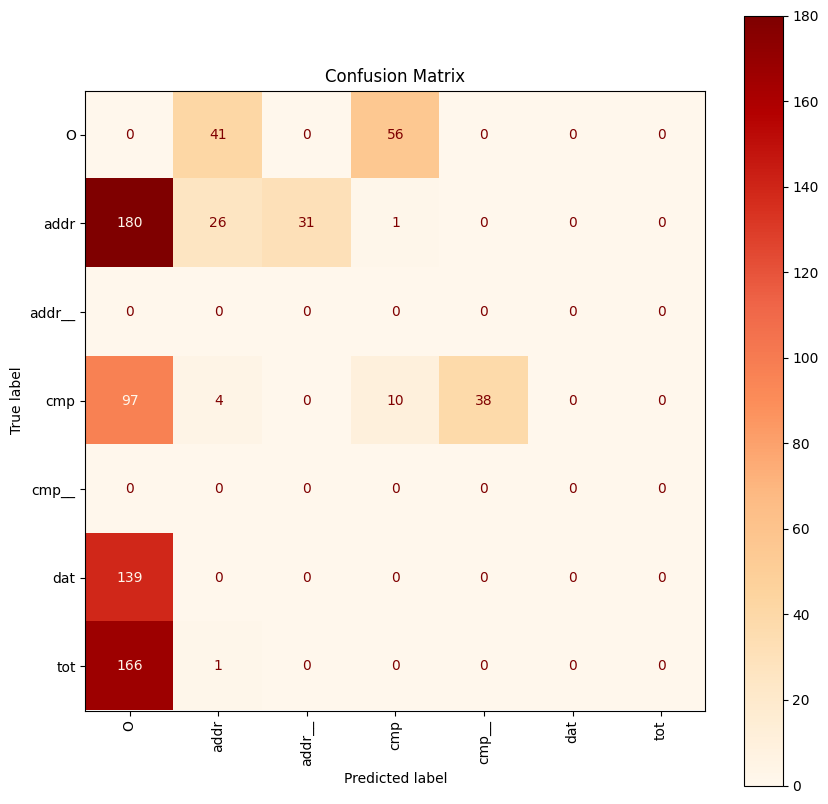

In [ ]:
plot_confusion_matrix(cm, cm_labels, show=True, save=False, img_path=None, normalize=None, decimal_places=2, figsize=(10,10), SMALL_SIZE=10, MEDIUM_SIZE=10, BIGGER_SIZE=12, cmap='OrRd', xticks_rotation='vertical', title='Confusion Matrix')

### CRF

Let's try conditional random fields instead:

In [ ]:
from datetime import datetime

Defining some auxiliary fuctions needed to get additional features:

In [ ]:
def is_date(str):

  format = "%d-%m-%Y"
  res = True
  try:
      res = bool(datetime.strptime(str, format))
  except ValueError:
      res = False
  return res

In [ ]:
def is_money(str):

    # Regex to check valid US Currency
    regex = re.compile("^\\$?(\\d{1, 3}(\\, \\d{3})*|(\\d+))(\\.\\d{2})?$")

    # If the string is empty
    # return false
    if (str == None):
        return False

    # Return if the string
    # matched the ReGex
    if(re.search(regex, str)):
        return True
    else:
        return False

In [ ]:
def is_total(str):

  if str.lower() == 'total' or similar(str.lower(), 'total')>=0.75:
      return True
  else:
      return False

In [ ]:
is_total('TOTAI')

True

Add features to text from OCR:

In [ ]:
def word2features(sent, i):
    word = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-4:]': word[-4:],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-1:]': word[-1:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isalpha()': word.isalpha(),
        'word.is_date()': is_date(word),
        'word.is_money()': is_money(word),
        'word.isdigit()': word.isdigit(),

    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word.isalpha()': word1.isalpha(),
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.is_total()': is_total(word1),
        })
    else:
        features['BOS'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            '-2:word.lower()': word2.lower(),
            '-2:word.istitle()': word2.istitle(),
            '-2:word.isupper()': word2.isupper(),
            '-2:word.isalpha()': word2.isalpha(),
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.is_total()': is_total(word2),
        })

    if i > 2:
        word3 = sent[i-3][0]
        features.update({
            '-3:word.lower()': word3.lower(),
            '-3:word.istitle()': word3.istitle(),
            '-3:word.isupper()': word3.isupper(),
            '-3:word.isalpha()': word3.isalpha(),
            '-3:word.isdigit()': word3.isdigit(),
            '-3:word.is_total()': is_total(word3),
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word.isalpha()': word1.isalpha(),
            '+1:word.isdigit()': word1.isdigit(),

        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for label, token in sent]

def sent2tokens(sent):
    return [token for label, token  in sent]

In [ ]:
X_train = [sent2features(s) for s in train_data_proc]
y_train = [sent2labels(s) for s in train_data_proc]

Defining a CRF model:

In [ ]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

Fitting the model:

In [ ]:
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

Assigning tags to the testing set:

In [ ]:
test_data = []

for i in range(len(test_corpus)):
  filename = test_filenames[i].split('.')[0]
  with open(DATA_PATH + filename +'.txt') as f:
    lines = f.read()
  parsed_json = json.loads(lines)
  item = assign_tags(text_preprocess(test_corpus[i]), parsed_json)
  test_data.append(item)


In [ ]:
X_test = [sent2features(s) for s in test_data]
y_test = [sent2labels(s) for s in test_data]

Make predictions:

In [ ]:
pred = crf.predict(X_test)

In [ ]:
labels = list(crf.classes_)
labels.remove('O')

Calcualting F1 score:

In [ ]:
metrics.flat_f1_score(y_test, pred,
                      average='weighted', labels=labels)

0.8994777555414941

In [ ]:
cr, cm, cm_labels = crm(y_test, pred, scheme='BIO')

True Entities: 693
Pred Entities: 491 

True Entities with 3 or more tags: 184
Pred Entities with 3 or more tags: 175 

True positives:  371
False positives (true = 'O'):  70
False positives (true <> pred):  50
ToT False positives:  120
False negatives:  272 



Classification report:

In [ ]:
cr

,precision,recall,f1_score,true_entities,pred_entities
addr,0.73,0.43,0.54,238.00,139.00
tot,0.69,0.26,0.38,167.00,64.00
cmp,0.92,0.66,0.77,149.00,108.00
dat,0.96,0.91,0.93,139.00,131.00
cmp__,0.00,0.00,0.00,0.00,17.00
addr__,0.00,0.00,0.00,0.00,31.00
tot__,0.00,0.00,0.00,0.00,1.00
micro_avg,0.76,0.54,0.63,693.00,491.00
macro_avg,0.47,0.32,0.38,693.00,491.00
weighted_avg,0.81,0.54,0.63,693.00,491.00


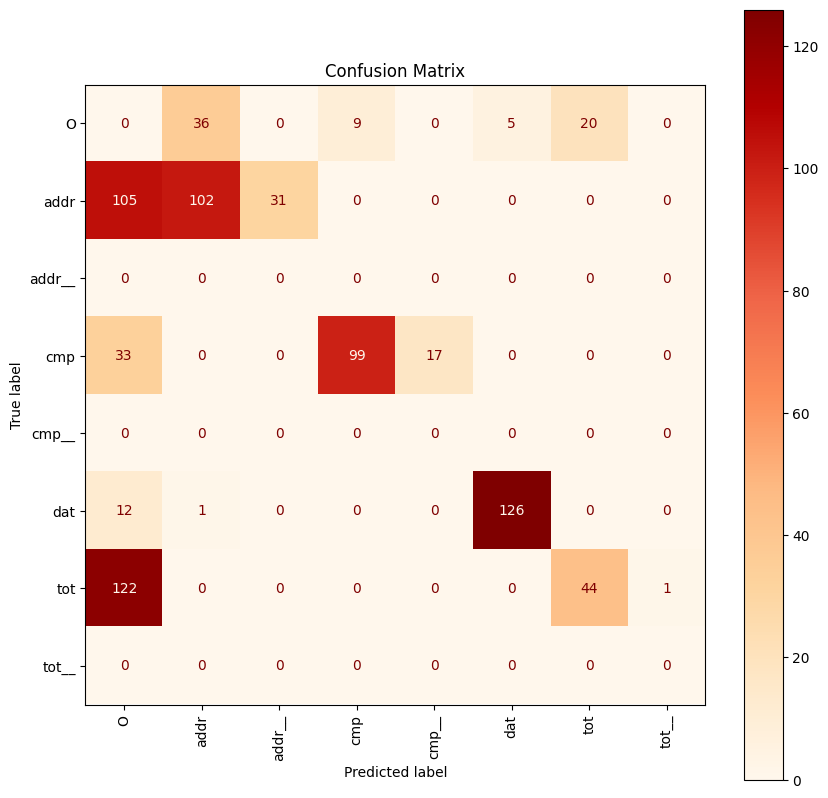

In [ ]:
plot_confusion_matrix(cm, cm_labels, show=True, save=False, img_path=None, normalize=None, decimal_places=2, figsize=(10,10), SMALL_SIZE=10, MEDIUM_SIZE=10, BIGGER_SIZE=12, cmap='OrRd', xticks_rotation='vertical', title='Confusion Matrix')

This time result is not bad. The model identifies target fields with good accuracy especially Date and Company Name.

#### Char-based RNN

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, Dataset
from transformers import BertTokenizerFast, BertConfig, BertForTokenClassification
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
receipt = img_collection[15]


In [ ]:
processed_img = img_processing(receipt)

To train char-based RNN first of all I need to obtain characters and coordinates of their boxes for every receipt image:

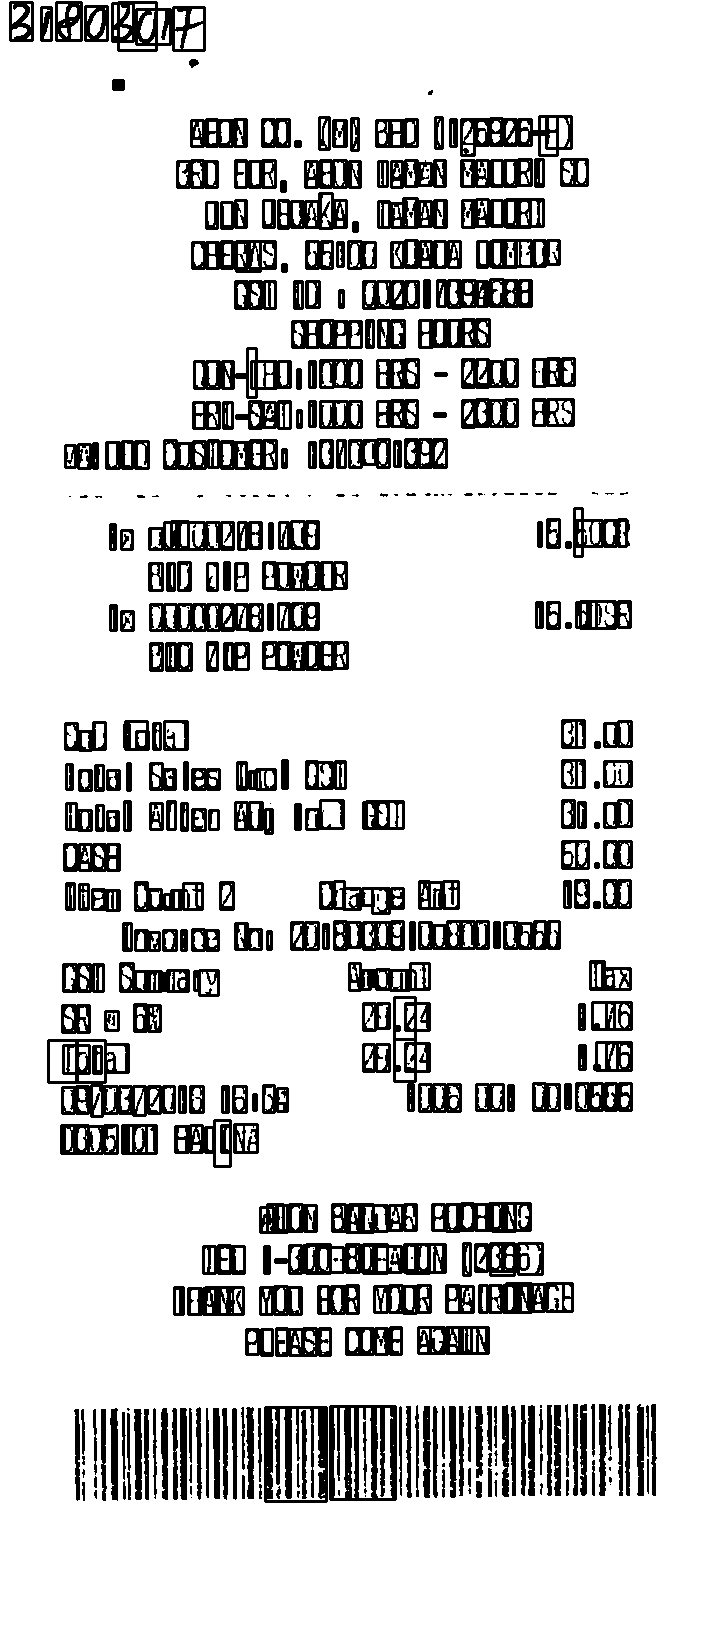

In [ ]:
options = "--psm 4 --oem 1"

height = processed_img.shape[0]
width = processed_img.shape[1]

d = pytesseract.image_to_boxes(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB), output_type=Output.DICT,	config=options)
n_boxes = len(d['char'])

chars = []

for i in range(n_boxes):
    (text,x1,y2,x2,y1) = (d['char'][i],d['left'][i],d['top'][i],d['right'][i],d['bottom'][i])
    chars.append(d['char'][i])
    cv2.rectangle(processed_img, (x1,height-y1), (x2,height-y2) , (0,255,0), 2)
cv2_imshow(processed_img)


In [ ]:
max_len = 1000

Function to clear list of chars obtained from OCR and lowercase chars:  

In [ ]:
def clear_chars(char_list):
  tmp_list = []
  chars_to_remove = '!"#$%&*:;<=>?[\]^_`{|}~\t\n€«“‘’°©»®”™§¢—'
  chars_to_remove += "'"
  for c in char_list:
    if c not in chars_to_remove:
      tmp_list.append(c.lower())

  return tmp_list

In [ ]:
len(chars)

558

In [ ]:
clearned = clear_chars(chars)
len(clearned)

549

In [ ]:
def string_vectorizer(strng, alphabet=string.ascii_lowercase):
    vector = [[0 if char != letter else 1 for char in alphabet]
                  for letter in strng]
    return vector

At the moment I can't figure out how to generate labels for a char-wise OCR output. Given instruction said as following: <br>

*   Iterate over target fields list
*   **Each char with bounding box inside the target bounding box should be labelled as considering field class**
*   Encode targets to numerical representations (class id). Use special class for chars that don’t correspond to any target class.
*   Pad labels sequence

But we don't have **"target bounding boxes"** in our data, so it is impossible to produce labels like this.


### Bi-LSTM + OCR

In [ ]:
train_data_proc[0]

Setting up device-agnostic code:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Defining some helper functions:

In [ ]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix.keys() else to_ix[unk_tag] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [ ]:
def plot_train_progress(train_loss, train_acc, epochs):
    # Plots learning curves for the loss, and the metric (default - accuracy)

    epoch_count = [i for i in range(1,epochs+1)]
    m_name = 'Accuracy'


    plt.subplots(1, 2, figsize=(24, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count, train_loss, label="Train loss")
#    plt.plot(epoch_count, test_loss, label="Test loss")
    plt.grid(linestyle=':', color='k')
    plt.title("Training loss curve")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();

    plt.subplot(1, 2, 2)
    plt.plot(epoch_count, train_acc, label="Train " + m_name )
#    plt.plot(epoch_count, test_acc, label="Test " + m_name)
    plt.grid(linestyle=':', color='k')
    plt.title("Training " + m_name + " curve")
    plt.ylabel(m_name)
    plt.xlabel("Epochs")
    plt.legend();
    plt.show()

In [ ]:
def model_save(model, name):
  # Saves models parameters

  # Create model save path
  MODEL_NAME = name
  MODEL_SAVE_PATH = FILE_PATH + MODEL_NAME

  # Save the model state dict
  print(f"Saving model to: {MODEL_SAVE_PATH}")
  torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

In [ ]:
def load_model(model_cls, name):
  # Loads model's parameters

  loaded_model_1 = model_cls

  MODEL_SAVE_PATH = FILE_PATH + name

  # Load model state dict
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

  # Put model to target device
  loaded_model_1.to(device)

  print(f"Loaded model:\n{loaded_model_1}")
  print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
  return loaded_model_1

In [ ]:
def get_test_data(tag_word_list):
  sents = []
  tags = []
  for item in tag_word_list:
    sent = []
    tagline = []
    for pair in item:
      sent.append(pair[1])
      tagline.append(pair[0])
    sents.append(sent)
    tags.append(tagline)
  return sents, tags

Set hyperparameters for the model and training process:

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
pad_tag = "<pad>"
unk_tag = "<unk>"
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
EPOCHS = 5

Define the LSTM model

In [ ]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2, num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

Define train and test sets. As the model is designed to handle single sentences not batches, we dont need to align all sentences to the one length:

In [ ]:
%%time
train_sents, train_tags = get_test_data(train_data_proc)
test_sents, test_tags = test_data_proc, test_tags_proc

CPU times: user 14.1 ms, sys: 933 µs, total: 15 ms
Wall time: 14.9 ms


In [ ]:
train_sents[0]

In [ ]:
zero_len_idx = []
for i in range(len(train_sents)):
  if len(train_sents[i]) == 0:
    zero_len_idx.append(i)
zero_len_idx

[120, 185, 194, 196, 206, 207, 209]

In [ ]:
train_sents = [ele for idx, ele in enumerate(train_sents) if idx not in zero_len_idx]
train_tags = [ele for idx, ele in enumerate(train_tags) if idx not in zero_len_idx]

In [ ]:
train_data = tuple(zip(train_sents, train_tags))

In [ ]:
len(train_sents), len(train_tags)

(494, 494)

Define encoding dictionaries - `word_to_ix` and `tag_to_ix`:

In [ ]:
word_to_ix = {}
tag_to_ix = {}

for sentence, tags in train_data:
    for word in sentence:
      if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)

    for tag in tags:
      if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

# Add start and stop tags here
tag_to_ix[START_TAG] = len(tag_to_ix)
tag_to_ix[STOP_TAG] = len(tag_to_ix)
word_to_ix[unk_tag] = len(word_to_ix)

In [ ]:
tag_to_ix

{'O': 0,
 'B-cmp': 1,
 'I-cmp': 2,
 'B-addr': 3,
 'I-addr': 4,
 'B-dat': 5,
 'B-tot': 6,
 'I-dat': 7,
 'I-tot': 8,
 '<START>': 9,
 '<STOP>': 10}

In [ ]:
word_to_ix

Instantiating the model and optimizer:

In [ ]:
lstm_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
optimizer = optim.SGD(lstm_model.parameters(), lr=0.01, weight_decay=1e-4)
lstm_model.to(device)
print(lstm_model)

BiLSTM_CRF(
  (word_embeds): Embedding(18992, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=11, bias=True)
)


Check predictions before training:

In [ ]:
len(train_data[0][0])

103

In [ ]:
with torch.inference_mode():
    precheck_sent = prepare_sequence(train_data[0][0], word_to_ix)
    precheck_tags = torch.tensor([tag_to_ix[t] for t in train_data[0][1]], dtype=torch.long)
    print(lstm_model(precheck_sent.to(device)))

(tensor(225.7548, device='cuda:0'), [5, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 6, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 1, 4, 0, 6, 1, 4, 0, 6])


In [ ]:
len(precheck_tags)

103

In [ ]:
precheck_tags

tensor([0, 1, 2, 2, 2, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0])

As we can see model doesn't do well before training. So let's train it:

In [ ]:
%%time

counter = 0
print_every = 50
clip=5

train_losses = []
train_accs = []
# Make sure prepare_sequence from earlier in the LSTM section is loaded
for epoch in range(EPOCHS):
    epoch_losses = []
    epoch_accs = []
    for sentence, tags in tqdm(train_data, total = len(train_data)):
        counter += 1
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        lstm_model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix).to(device)
        targets = torch.tensor([tag_to_ix[t] for t in tags], dtype=torch.long).to(device)

        score, y_pred = lstm_model(sentence_in)

        # Step 3. Run our forward pass.
        loss = lstm_model.neg_log_likelihood(sentence_in, targets)

        acc = metrics.flat_accuracy_score(targets.cpu().unsqueeze(0).tolist(), torch.Tensor(y_pred).unsqueeze(0).tolist())

        epoch_losses.append(loss.detach().cpu().float().numpy())
        epoch_accs.append(acc)
        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()

        nn.utils.clip_grad_norm_(lstm_model.parameters(), clip)
        optimizer.step()
        if counter % print_every == 0:
          print("Epoch: {}/{}...".format(epoch+1, EPOCHS),
                          "Step: {}...".format(counter),
                          "Train Loss: {:.4f}...".format(np.mean(epoch_losses)), # loss.item()
                          "Train Accuracy: {:.4f}...".format(np.mean(epoch_accs)))
                          #"Val Loss: {:.4f}...".format(np.mean(val_losses)),
                          #"Val Accuracy: {:.4f}".format(np.mean(val_accs)))
          train_losses.append(np.mean(epoch_losses))
          train_accs.append(np.mean(epoch_accs))

  0%|          | 0/494 [00:00<?, ?it/s]

Epoch: 1/5... Step: 50... Train Loss: 204.5351... Train Accuracy: 0.3912...
Epoch: 1/5... Step: 100... Train Loss: 149.6351... Train Accuracy: 0.6100...
Epoch: 1/5... Step: 150... Train Loss: 129.9157... Train Accuracy: 0.6843...
Epoch: 1/5... Step: 200... Train Loss: 116.1898... Train Accuracy: 0.7145...
Epoch: 1/5... Step: 250... Train Loss: 103.3096... Train Accuracy: 0.7396...
Epoch: 1/5... Step: 300... Train Loss: 95.0047... Train Accuracy: 0.7612...
Epoch: 1/5... Step: 350... Train Loss: 89.0975... Train Accuracy: 0.7716...
Epoch: 1/5... Step: 400... Train Loss: 83.9599... Train Accuracy: 0.7771...
Epoch: 1/5... Step: 450... Train Loss: 80.6640... Train Accuracy: 0.7844...


  0%|          | 0/494 [00:00<?, ?it/s]

Epoch: 2/5... Step: 500... Train Loss: 36.6327... Train Accuracy: 0.9051...
Epoch: 2/5... Step: 550... Train Loss: 39.2586... Train Accuracy: 0.8928...
Epoch: 2/5... Step: 600... Train Loss: 42.3419... Train Accuracy: 0.8771...
Epoch: 2/5... Step: 650... Train Loss: 40.7771... Train Accuracy: 0.8733...
Epoch: 2/5... Step: 700... Train Loss: 39.6544... Train Accuracy: 0.8705...
Epoch: 2/5... Step: 750... Train Loss: 37.8525... Train Accuracy: 0.8816...
Epoch: 2/5... Step: 800... Train Loss: 38.9013... Train Accuracy: 0.8792...
Epoch: 2/5... Step: 850... Train Loss: 39.3772... Train Accuracy: 0.8749...
Epoch: 2/5... Step: 900... Train Loss: 39.0420... Train Accuracy: 0.8715...
Epoch: 2/5... Step: 950... Train Loss: 39.9222... Train Accuracy: 0.8699...


  0%|          | 0/494 [00:00<?, ?it/s]

Epoch: 3/5... Step: 1000... Train Loss: 30.1919... Train Accuracy: 0.9229...
Epoch: 3/5... Step: 1050... Train Loss: 34.2384... Train Accuracy: 0.8975...
Epoch: 3/5... Step: 1100... Train Loss: 37.2051... Train Accuracy: 0.8897...
Epoch: 3/5... Step: 1150... Train Loss: 35.0456... Train Accuracy: 0.8918...
Epoch: 3/5... Step: 1200... Train Loss: 34.4194... Train Accuracy: 0.8879...
Epoch: 3/5... Step: 1250... Train Loss: 32.3757... Train Accuracy: 0.8986...
Epoch: 3/5... Step: 1300... Train Loss: 34.0023... Train Accuracy: 0.8937...
Epoch: 3/5... Step: 1350... Train Loss: 34.9990... Train Accuracy: 0.8869...
Epoch: 3/5... Step: 1400... Train Loss: 34.2732... Train Accuracy: 0.8860...
Epoch: 3/5... Step: 1450... Train Loss: 35.5073... Train Accuracy: 0.8836...


  0%|          | 0/494 [00:00<?, ?it/s]

Epoch: 4/5... Step: 1500... Train Loss: 27.4648... Train Accuracy: 0.9262...
Epoch: 4/5... Step: 1550... Train Loss: 31.4603... Train Accuracy: 0.9025...
Epoch: 4/5... Step: 1600... Train Loss: 34.2245... Train Accuracy: 0.8964...
Epoch: 4/5... Step: 1650... Train Loss: 32.4986... Train Accuracy: 0.9036...
Epoch: 4/5... Step: 1700... Train Loss: 32.0870... Train Accuracy: 0.8984...
Epoch: 4/5... Step: 1750... Train Loss: 29.7073... Train Accuracy: 0.9076...
Epoch: 4/5... Step: 1800... Train Loss: 31.3256... Train Accuracy: 0.9034...
Epoch: 4/5... Step: 1850... Train Loss: 32.8894... Train Accuracy: 0.8924...
Epoch: 4/5... Step: 1900... Train Loss: 31.9485... Train Accuracy: 0.8944...
Epoch: 4/5... Step: 1950... Train Loss: 33.8996... Train Accuracy: 0.8914...


  0%|          | 0/494 [00:00<?, ?it/s]

Epoch: 5/5... Step: 2000... Train Loss: 23.9313... Train Accuracy: 0.9405...
Epoch: 5/5... Step: 2050... Train Loss: 32.5873... Train Accuracy: 0.9078...
Epoch: 5/5... Step: 2100... Train Loss: 33.4023... Train Accuracy: 0.9032...
Epoch: 5/5... Step: 2150... Train Loss: 30.8431... Train Accuracy: 0.9132...
Epoch: 5/5... Step: 2200... Train Loss: 30.7440... Train Accuracy: 0.9072...
Epoch: 5/5... Step: 2250... Train Loss: 28.4943... Train Accuracy: 0.9153...
Epoch: 5/5... Step: 2300... Train Loss: 29.5512... Train Accuracy: 0.9117...
Epoch: 5/5... Step: 2350... Train Loss: 31.3745... Train Accuracy: 0.8996...
Epoch: 5/5... Step: 2400... Train Loss: 31.7333... Train Accuracy: 0.9011...
Epoch: 5/5... Step: 2450... Train Loss: 32.5088... Train Accuracy: 0.8993...
CPU times: user 29min 45s, sys: 6.62 s, total: 29min 51s
Wall time: 29min 11s


In [ ]:
plot_losses = []
plot_accs = []
num_points = len(train_data)%50
prev=0
for i in range(num_points, len(train_data), num_points):
  avg_loss = sum(train_losses[prev:i])/num_points
  avg_acc = sum(train_accs[prev:i])/num_points
  plot_losses.append(avg_loss)
  plot_accs.append(avg_acc)
  prev += num_points

In [ ]:
len(plot_accs)

11

In [ ]:
len(train_losses)

494

These are training curves for loss and accuracy:

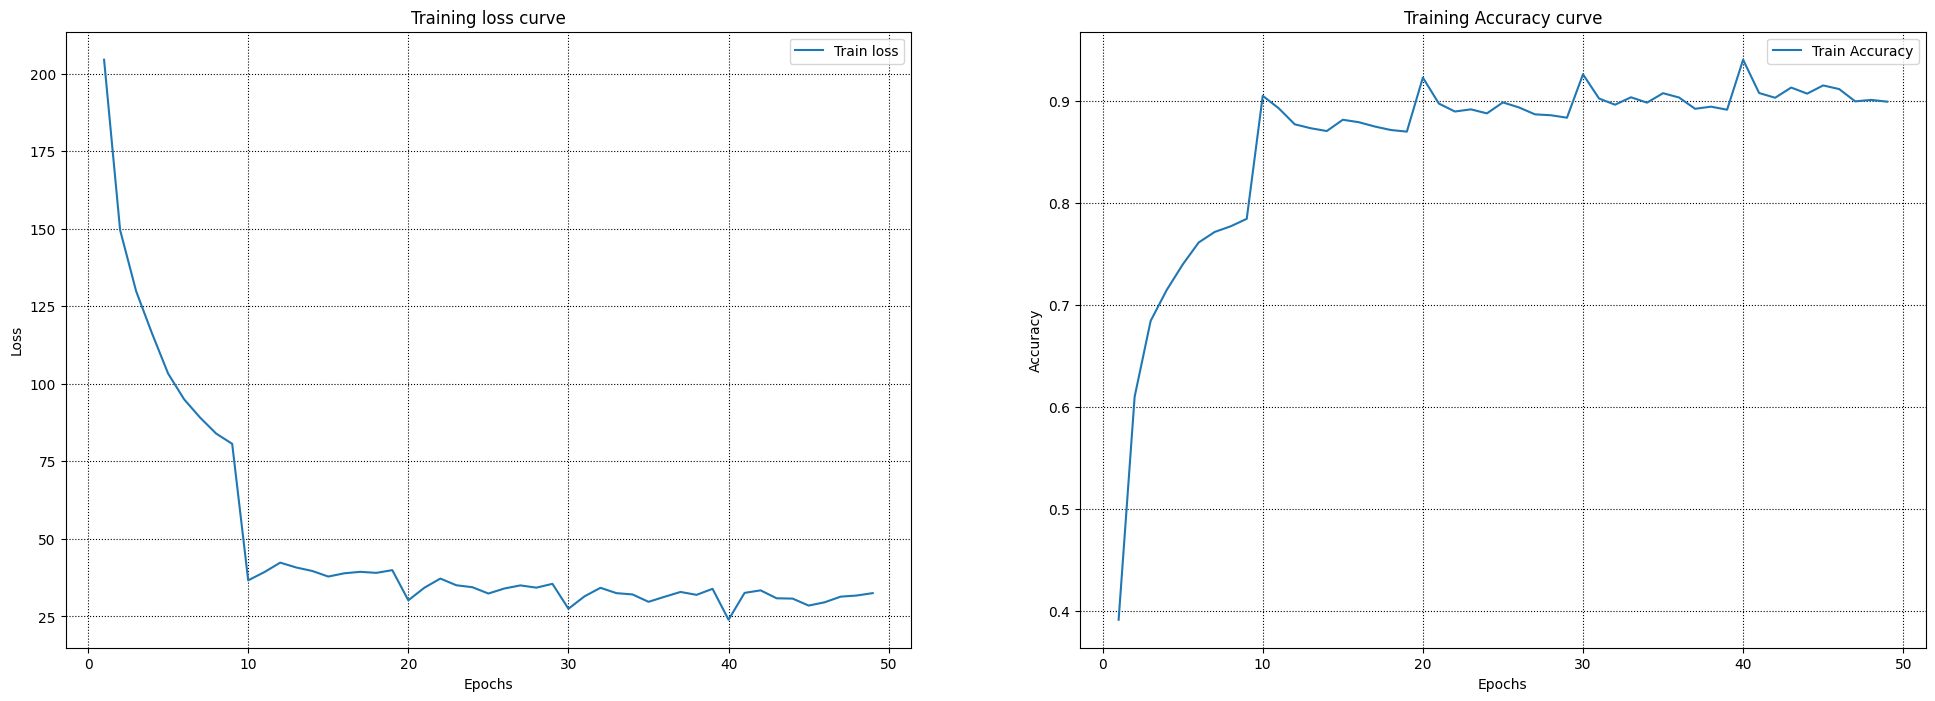

In [ ]:
plot_train_progress(train_losses, train_accs, 49)

Check how the model predicts after training:

In [ ]:
with torch.inference_mode():
    precheck_sent = prepare_sequence(test_sents[0], word_to_ix)
    print(lstm_model(precheck_sent.to(device)))

(tensor(553.0689, device='cuda:0'), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
len(test_sents[0])

112

In [ ]:
tag_id = []
for tag in test_tags[0]:
  tag_id.append(tag_to_ix[tag])
tag_id

Looks good. Saving the model:

In [ ]:
model_save(lstm_model, 'ner_ocr_lstm_crf')

Saving model to: /content/drive/MyDrive/ds_data/OCR/ner_ocr_lstm_crf


In [ ]:
lstm_model = load_model(BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM), 'ner_lstm_crf')

Loaded model:
BiLSTM_CRF(
  (word_embeds): Embedding(31814, 128)
  (lstm): LSTM(128, 128, bidirectional=True)
  (hidden2tag): Linear(in_features=256, out_features=19, bias=True)
)
Model on device:
cuda:0


Inference - doesn't works because of abcense of `<unk>` tag in word_to_ix dict :(

In [ ]:
with torch.inference_mode():
  preds = []
  for sent in test_sents:
    precheck_sent = prepare_sequence(sent, word_to_ix)
    prediction = lstm_model(precheck_sent.to(device))
    preds.append(prediction)
len(preds)

125

In [ ]:
predictions = [pred for h, pred in preds]

In [ ]:
len(predictions)

125

In [ ]:
tag_to_ix

{'O': 0,
 'B-cmp': 1,
 'I-cmp': 2,
 'B-addr': 3,
 'I-addr': 4,
 'B-dat': 5,
 'B-tot': 6,
 'I-dat': 7,
 'I-tot': 8,
 '<START>': 9,
 '<STOP>': 10}

In [ ]:
pred_tags = []
for pred in predictions:
  pred_tag = [list(tag_to_ix.keys())[list(tag_to_ix.values()).index(t)] for t in pred]
  pred_tags.append(pred_tag)

In [ ]:
pred_tags[:1]

In [ ]:
test_tags

In [ ]:
cr, cm, cm_labels = crm(test_tags, pred_tags, scheme='BIO')

True Entities: 693
Pred Entities: 186 

True Entities with 3 or more tags: 184
Pred Entities with 3 or more tags: 141 

True positives:  103
False positives (true = 'O'):  34
False positives (true <> pred):  49
ToT False positives:  83
False negatives:  541 



Classification report:

In [ ]:
cr

,precision,recall,f1_score,true_entities,pred_entities
addr,0.71,0.16,0.27,238.00,55.00
tot,0.89,0.10,0.17,167.00,18.00
cmp,0.65,0.26,0.37,149.00,60.00
dat,1.00,0.06,0.12,139.00,9.00
addr__,0.00,0.00,0.00,0.00,22.00
cmp__,0.00,0.00,0.00,0.00,22.00
micro_avg,0.55,0.15,0.23,693.00,186.00
macro_avg,0.54,0.10,0.16,693.00,186.00
weighted_avg,0.80,0.15,0.24,693.00,186.00


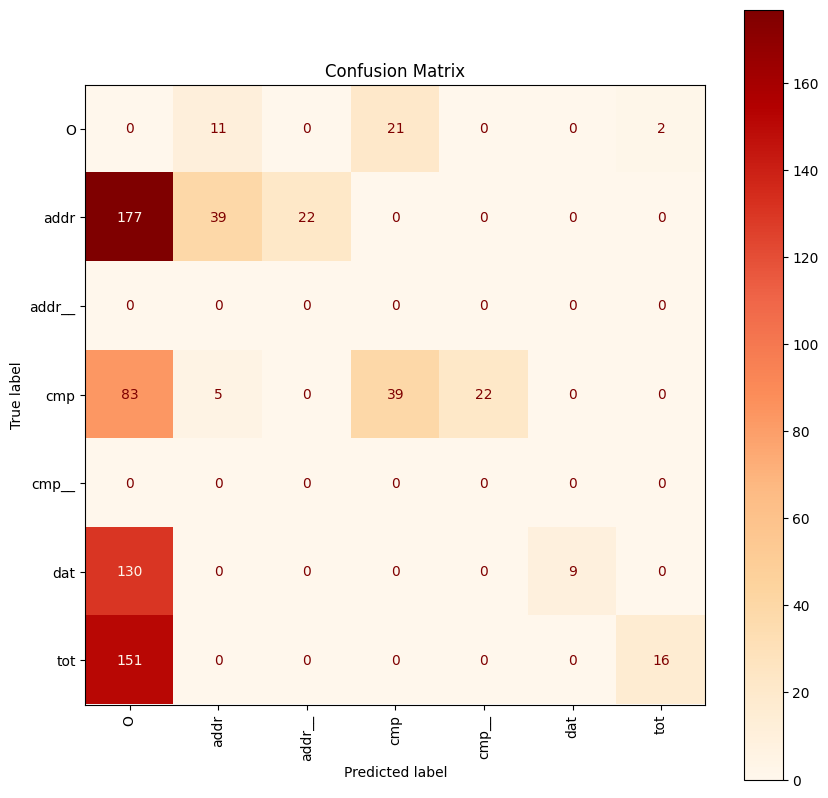

In [ ]:
plot_confusion_matrix(cm, cm_labels, show=True, save=False, img_path=None, normalize=None, decimal_places=2, figsize=(10,10), SMALL_SIZE=10, MEDIUM_SIZE=10, BIGGER_SIZE=12, cmap='OrRd', xticks_rotation='vertical', title='Confusion Matrix')

### Bi-LSTM + CRF (TF-Keras)

In [ ]:
import tensorflow as tf
import keras
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
#from keras_contrib.layers import CRF

import tensorflow_addons as tfa

#from tf_crf_layer.loss import crf_loss, ConditionalRandomFieldLoss
#from tf_crf_layer.metrics.sequence_span_accuracy import SequenceSpanAccuracy

#from tf_crf_layer.layer import CRF
#from tf_crf_layer.loss import crf_loss
#from tf_crf_layer.metrics import crf_accuracy

In [ ]:
BATCH_SIZE = 2
EPOCHS = 5
MAX_LEN = 256
EMBEDDING = 24

In [ ]:
train_sents, train_tags = get_test_data(train_data_proc)
test_sents, test_tags = test_data_proc, test_tags_proc

In [ ]:
zero_len_idx = []
for i in range(len(train_sents)):
  if len(train_sents[i]) == 0:
    zero_len_idx.append(i)
zero_len_idx

[120, 185, 194, 196, 206, 207, 209]

In [ ]:
train_sents = [ele for idx, ele in enumerate(train_sents) if idx not in zero_len_idx]
train_tags = [ele for idx, ele in enumerate(train_tags) if idx not in zero_len_idx]

In [ ]:
train_data = tuple(zip(train_sents, train_tags))

In [ ]:
len(train_sents), len(train_tags)

(494, 494)

In [ ]:
train_vocab.extend(test_vocab)

In [ ]:
vocab = train_vocab

In [ ]:
n_words = len(vocab)

In [ ]:
word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

In [ ]:
idx2word = {i: w for w, i in word2idx.items()}

In [ ]:
flat_tags = [item for sublist in train_tags for item in sublist]
tags = list(set(flat_tags))
tags

['B-addr', 'I-dat', 'B-tot', 'B-cmp', 'I-addr', 'B-dat', 'I-tot', 'O', 'I-cmp']

In [ ]:
n_tags = len(tags)

In [ ]:
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
X_train = [[word2idx[w] for w in s] for s in train_sents]
X_train = pad_sequences(maxlen=MAX_LEN, sequences=X_train, padding="post", value=word2idx["PAD"])
y_train = [[tag2idx[w] for w in s] for s in train_tags]
y_train = pad_sequences(maxlen=MAX_LEN, sequences=y_train, padding="post", value=tag2idx["PAD"])
y_train = [to_categorical(i, num_classes=n_tags+1) for i in y_train]

In [ ]:
X_test = [[word2idx[w] for w in s] for s in test_sents]
X_test = pad_sequences(maxlen=MAX_LEN, sequences=X_test, padding="post", value=word2idx["PAD"])
y_test = [[tag2idx[w] for w in s] for s in test_tags]
y_test = pad_sequences(maxlen=MAX_LEN, sequences=y_test, padding="post", value=tag2idx["PAD"])
y_test = [to_categorical(i, num_classes=n_tags+1) for i in y_test]  # n_tags+1(PAD)

In [ ]:
print('Raw Sample: ', ' '.join([w for w in train_sents[0]]))
print('Raw Label: ', ' '.join([w for w in train_tags[0]]))
print('After processing, sample:', X_train[0])
print('After processing, labels:', y_train[0])

Raw Sample:  Py 99 SPEED MART S/B (519537-X) LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1132-PI 56 6ST ID. NO s 000181747712 INVOICE NO : 18301/102/T0305 03: 16PHi 569337 07-02-18 2471 888 LYCHEES IN SYRUP S = RM10,14 s 03 X RK 3.38 270_C5R 6 CSR GULA 12%1K6* RM3S.20 z eae ee einen nen eecenee Total Sales (Inclusive GST) RM 45.34 Rounding Adjustment RM Ot Rounding RM 45.35 ~ CREDIT RM = 45,35 CHANGE RM 00 6ST Sumnary Amount (RH) Tax(RM) s 2 Of 9.S7 5? z= 0s 38.20 00 A526 Thank You. Please come again Keep the invoice for applicable returns
Raw Label:  O B-cmp I-cmp I-cmp I-cmp O B-addr I-addr I-addr I-addr I-addr I-addr I-addr I-addr I-addr I-addr O O O O O O O O O O O O O O B-dat O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-tot O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
After processing, sample: [ 8593 19048 20940 24983 21417 25263 20950 24200 20763 19111 23712 24525
 20473 21503 20790 19405 18012  6480 20605

In [ ]:
# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = tfa.layers.CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)

adam = keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
loss_fn = tfa.losses.SigmoidFocalCrossEntropy()
model.compile(optimizer='rmsprop', loss=loss_fn, metrics=['accuracy',])

model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_30 (Embedding)    (None, 256, 24)           606576    
                                                                 
 bidirectional_30 (Bidirecti  (None, 256, 100)         30000     
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 256, 50)          5050      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                [(None, 256),             630       
                              (None, 256, 10),                   
                              (None,),                    

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.1, verbose=2)

Epoch 1/5


TypeError: ignored

Custom loss and train_loop

In [ ]:
def build_embedding_bilstm_crf_model(
    vocab_size: int, embed_dims: int, lstm_unit: int, tag_size: int
) -> tf.keras.Model:
    x = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name="x")
    y = tf.keras.layers.Embedding(vocab_size+2, embed_dims, mask_zero=True)(x)
    y = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_unit, return_sequences=True)
    )(y)
    decode_sequence, potentials, sequence_length, kernel = tfa.layers.CRF(tag_size+1)(y)

    return tf.keras.Model(
        inputs=x, outputs=[decode_sequence, potentials, sequence_length, kernel]
    )

In [ ]:
model = build_embedding_bilstm_crf_model(n_words, EMBEDDING, 50, n_tags)

In [ ]:
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 256)]             0         
                                                                 
 embedding_29 (Embedding)    (None, 256, 24)           606576    
                                                                 
 bidirectional_29 (Bidirecti  (None, 256, 100)         30000     
 onal)                                                           
                                                                 
 crf_27 (CRF)                [(None, 256),             1130      
                              (None, 256, 10),                   
                              (None,),                           
                              (10, 10)]                          
                                                                 
Total params: 637,706
Trainable params: 637,706
Non-traina

In [ ]:
@tf.function
def crf_loss_func(potentials, sequence_length, kernel, y):
    crf_likelihood, _ = tfa.text.crf_log_likelihood(
        potentials, y, sequence_length, kernel
    )
    # likelihood to loss
    flat_crf_loss = -1 * crf_likelihood
    crf_loss = tf.reduce_mean(flat_crf_loss)

    return crf_loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.02)

train_loss = tf.keras.metrics.Mean(name="train_loss")

@tf.function(experimental_relax_shapes=True)
def train_step(x, y):
    with tf.GradientTape() as tape:
        decoded_sequence, potentials, sequence_length, kernel = model(x)
        crf_loss = crf_loss_func(potentials, sequence_length, kernel, y)
        loss = crf_loss + tf.reduce_sum(model.losses)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()

    for x, y in zip(X_train, y_train):
      train_step(x, y)

    print(f"Epoch {epoch + 1}, " f"Loss: {train_loss.result()}")

ValueError: ignored